### Experiments

#### decoder_state_dict_adamw_25e_bs64_ffdim_4096_heads_32_mseloss_0.07`
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=32,
    ff_dim=4096,
    output_channels=3
)
```

#### 'decoder_state_dict_adamw_50e_numblocks_2_ffdim_2048_heads_16_mseloss_0.06.pth'
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=2048,
    output_channels=3
)
```

#### decoder_state_dict_adamw_40e_numblocks_2_ffdim_4096_heads_16_mseloss_0.05.pth

```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
```

#### 'decoder_t8_preds_detr101dc5_adamw_30e_numblocks_2_ffdim_4096_heads_16.pth' -> loss 0.043 | train reconstruct loss: 0.041| test reconstruct loss: 0.21
This arch takes 6h to train on 150k objects. For Shanghaitech, this would mean 10x, so infeasible or not worth it. We have to reduce the overhead.
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
```

#### 'decoder_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_16.pth'
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
- Avenue: 20 epochs - 3h | Loss: 0.054 | Train Reconstruct Loss: 0.0521 | Test reconstruct loss: 0.21
- Shanghaitech (v2): 7 epochs -  9h | Loss: 0.26 | Train Reconstruct Loss: 0.21 | Test reconstruct loss: 0.?
- UBNormal
```

#### 'decoder_v2_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_32.pth'
```
decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=32,
    ff_dim=4096,
    output_channels=3
)
- Avenue: 50 epochs - 8h | Loss: 0.0371| Train Reconstruct Loss: 0.0365 | Test reconstruct loss: 0.211
```

#### 'decoder_v2_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_16.pth'
```
decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
- Avenue: 50 epochs - 7h | Loss: 0.0343| Train Reconstruct Loss: 0.033 | Test reconstruct loss: 0.23
```

-------

## autoencoder_ft_t8_decoder_v2_epoch_5.pth (TO CHANGE) (DETR DC5 101)

#### 'decoder_v2_t8_preds_detr101dc5_adam_numblocks_1_ffdim_2048_heads_8.pth'
```
decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=8,
    ff_dim=2048,
    output_channels=3
)
- Avenue: 20 epochs - 2h | Loss: 0.003| Train Reconstruct Loss: 0. 0.003 | Test reconstruct loss: 0.007
Epoch 1, Loss: 0.0523
Epoch 2, Loss: 0.0167
Epoch 3, Loss: 0.0118
Epoch 4, Loss: 0.0094
Epoch 5, Loss: 0.
Epoch 6, Loss: 0.0070
Epoch 7, Loss: 0.0064
Epoch 8, Loss: 0.0056
Epoch 9, Loss: 0.0054
Epoch 10, Loss: 0.0050
Epoch 11, Loss: 0.0047
Epoch 12, Loss: 0.0045
Epoch 13, Loss: 0.0042
Epoch 14, Loss: 0.0041
Epoch 15, Loss: 0.0039
Epoch 16, Loss: 0.0037
Epoch 17, Loss: 0.0036
Epoch 1```0034
Epoch ANG



## autoencoder_17t_t8_decoder_v2_?.pth (TO CH````)decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=8,
    ff_dim=2048,
    output_channels=3
)

- Avenue: 13 epochs - 1h+ | Loss: 0.004| Train Reconstruct Loss: 0. 0.004 | Test reconstruct loss: 0.009```ochs at least!
```

### Imports

In [1]:
import sys
sys.path.append('./ml-fastvit')

In [2]:
import timm
import torch
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as T
import torch.nn as nn
import models
import math
import matplotlib.pyplot as plt
import numpy as np
import gc

from torch import Tensor
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.models import create_model
from models.modules.mobileone import reparameterize_model
from PIL import Image
from urllib.request import urlopen

from UpsampleTransformerDecoder import UpsampleTransformerDecoder
from UpsampleTransformerDecoderV2 import UpsampleTransformerDecoderV2


# Before starting the training, make sure to clear any residual memory
gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
cuda


In [3]:
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    # img = std * img + mean  # unnormalize
    # img = np.clip(img, 0, 1)  # clip any values outside the range [0, 1]
    plt.imshow(img)
    plt.show()

In [4]:
def plot_images_vs_reconstructed_images(images, reconstructed_imgs):
    # Move images back to cpu for visualization
    images = images.cpu()
    reconstructed_imgs = reconstructed_imgs.cpu()
    
    # Display original and reconstructed images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Images')
    imshow(vutils.make_grid(images, padding=2, normalize=True))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Images')
    imshow(vutils.make_grid(reconstructed_imgs, padding=2, normalize=True))

In [5]:
transform = T.Compose([
        T.Resize((64, 64)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


### Initialize Encoder (Apple FastViT, T8)

In [6]:
# To Train from scratch/fine-tuning
encoder = create_model("fastvit_t8", fork_feat=True) # can turn fork_feat to False

checkpoint = torch.load('./pretrained/fastvit_t8.pth.tar')
encoder.load_state_dict(checkpoint['state_dict'], strict=False)

# For inference
# model.eval()      
# encoder = reparameterize_model(encoder)
encoder = encoder.to(device)
# encoder.eval()

### Initialize & Load Decoder

In [7]:
# Initialize the decoder
# decoder = UpsampleTransformerDecoder(
#     input_channels=384,
#     num_upsamples=5,  # Adjusted to 5 upsampling steps
#     num_blocks=1,
#     num_heads=16,
#     ff_dim=4096,
#     output_channels=3
# )

decoder = UpsampleTransformerDecoderV2(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=8,
    ff_dim=2048,
    output_channels=3
)

decoder = decoder.to(device)

In [8]:
# decoder_model_path = 'decoder_v2_t8_preds_yolov8_adamw_numblocks_1_ffdim_4096_heads_16.pth'

# # # Load the state dictionary
# decoder.load_state_dict(torch.load(decoder_model_path))

# # # This should be turned on only for test time. If we want to retrain, comment this line
# # # If you are using a GPU for the model, don't forget to move the decoder to the GPU
# decoder.to(device)

### Create AutoEncoder Architecture, given `encoder` and `decoder`

In [8]:
# autoencoder_path = 'autoencoder_ft_t8_decoder_v2_yolov8_epoch_17.pth'
# encoder.load_state_dict(torch.load(autoencoder_path)['encoder_state_dict'])
# decoder.load_state_dict(torch.load(autoencoder_path)['decoder_state_dict'])

NameError: name 'autoencoder_path' is not defined

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x[-1])
        return x

autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

# Avenue

### Declare Train Dataloader

In [11]:
train_dataset = datasets.ImageFolder(root='./datasets/Avenue Dataset/objects/train/', transform=transform)

# Create the DataLoader to load the dataset.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=6)

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 53648
    Root location: ./datasets/Avenue Dataset/objects/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### Training Loop 

In [12]:
# Freeze encoder weights
# for param in encoder.parameters():
#     param.requires_grad = False

# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
# optimizer.load_state_dict(torch.load(autoencoder_path)['optimizer_state_dict'])
# optimizer = optim.AdamW(decoder.parameters(), lr=0.001)

In [13]:
%%time
# Training loop
num_epochs = 20  # Define the number of epochs
losses = []
smallest_loss = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, _ in train_loader:  # Note the unpacking here to ignore the labels
        inputs = inputs.to(device)  # Move inputs to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # # Forward pass through encoder and then decoder
        # with torch.no_grad():  # We don't need to track gradients for the encoder
        # latent_representation = autoencoder(inputs)[-1]  # Get the last latent space representation

        # Decoder reconstruction from latent space
        # reconstructed_imgs = decoder(latent_representation)

        reconstructed_imgs = autoencoder(inputs)

        # Calculate loss
        loss = criterion(reconstructed_imgs, inputs)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

        losses.append(loss.item())

    if (running_loss / len(train_loader)) < smallest_loss:
        smallest_loss = running_loss / len(train_loader)
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'encoder_state_dict': autoencoder.encoder.state_dict(),
            'decoder_state_dict': autoencoder.decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss
        }
        torch.save(checkpoint, f'autoencoder_ft_t8_decoder_v2_yolov8_new_epoch_{epoch+1}_mseloss_{loss}.pth')
    
    # Print loss every epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')
    running_loss = 0.0

print('Finished Training')

Epoch 1, Loss: 0.0986
Epoch 2, Loss: 0.0368
Epoch 3, Loss: 0.0226
Epoch 4, Loss: 0.0170
Epoch 5, Loss: 0.0147
Epoch 6, Loss: 0.0129
Epoch 7, Loss: 0.0115
Epoch 8, Loss: 0.0104
Epoch 9, Loss: 0.0096
Epoch 10, Loss: 0.0090
Epoch 11, Loss: 0.0085
Epoch 12, Loss: 0.0080
Epoch 13, Loss: 0.0077
Epoch 14, Loss: 0.0073
Epoch 15, Loss: 0.0069
Epoch 16, Loss: 0.0066
Epoch 17, Loss: 0.0063
Epoch 18, Loss: 0.0061
Epoch 19, Loss: 0.0059
Epoch 20, Loss: 0.0057
Finished Training
CPU times: user 29min 45s, sys: 21min 28s, total: 51min 13s
Wall time: 52min 56s


### Visualize Reconstruction Loss on Train Batch

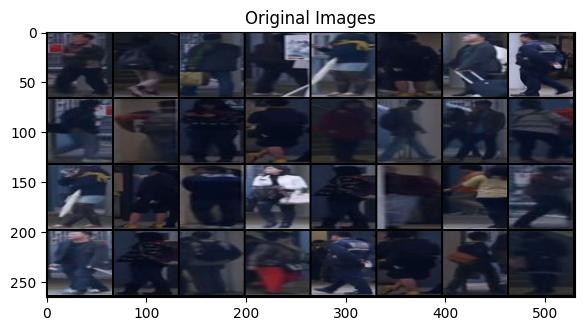

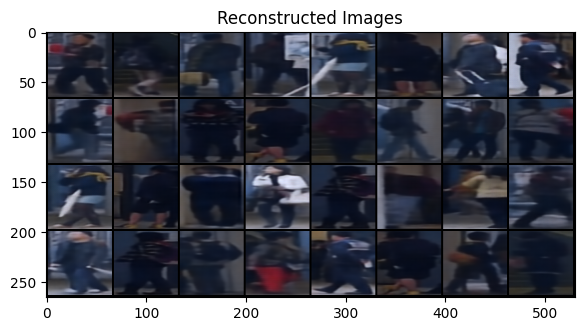

In [14]:
# Get a batch of images from your dataloader
dataiter = iter(train_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    # latent_representation = encoder(images)[-1]  # Get the last latent space representation
    # print(latent_representation.shape)
    # reconstructed_imgs = decoder(latent_representation)
    reconstructed_imgs = autoencoder(images)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

### Loss on Train Set

In [15]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in train_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # # Forward pass through the encoder and then the decoder
            # latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            # reconstructed_imgs = decoder(latent_representation)
            reconstructed_imgs = autoencoder(images)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the train set: {average_loss}')


Average reconstruction loss on the train set: 0.00535656874663417


### Save model state dict

In [ ]:
# Save the autoencoder state dictionary
# torch.save(autoencoder.state_dict(), 'decoder_v2_t8_preds_yolov8_adam_numblocks_1_ffdim_2048_heads_8.pth')

### Declare Test Data Loader

In [16]:
test_dataset = datasets.ImageFolder(root='./datasets/Avenue Dataset/objects/test/', transform=transform)

# Create the DataLoader to load the dataset.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 58941
    Root location: ./datasets/Avenue Dataset/objects/test/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### Visualize Reconstruction Loss on Test Batch

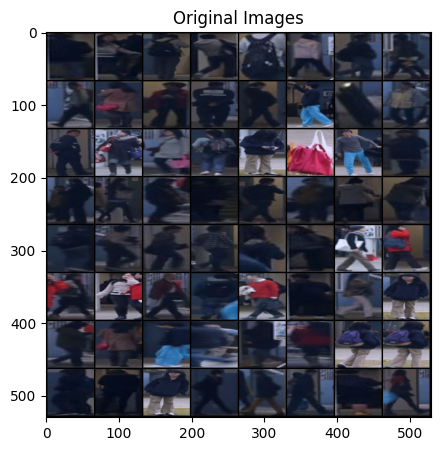

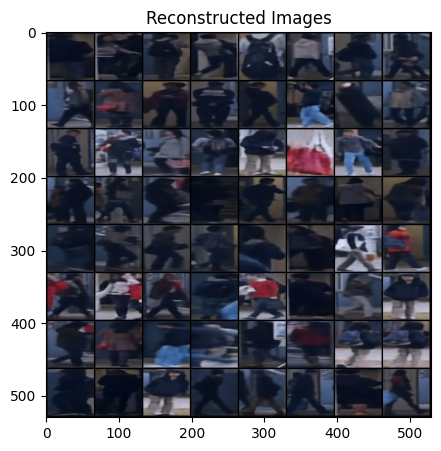

In [17]:
# Get a batch of images from your dataloader
dataiter = iter(test_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    # latent_representation = encoder(images)[-1]  # Get the last latent space representation
    # reconstructed_imgs = decoder(latent_representation)
    reconstructed_imgs = autoencoder(images)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

### Loss on Test Set

In [18]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in test_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # Forward pass through the encoder and then the decoder
            # latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            # reconstructed_imgs = decoder(latent_representation)
            reconstructed_imgs = autoencoder(images)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the test set: {average_loss}')

Average reconstruction loss on the test set: 0.016507514077971866


# ShanghaiTech

### Declare Train Dataloader

In [17]:
# Clear the CUDA cache
torch.cuda.empty_cache()

In [9]:
train_dataset = datasets.ImageFolder(root='./datasets/shanghaitech/objects/', transform=transform)

# Create the DataLoader to load the dataset.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 1458259
    Root location: ./datasets/shanghaitech/objects/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### Training Loop

In [10]:
# Freeze encoder weights
for param in encoder.parameters():
    param.requires_grad = False

# Set up loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(decoder.parameters(), lr=0.001)
optimizer = optim.AdamW(decoder.parameters(), lr=0.001)

In [11]:
%%time
# Training loop
num_epochs = 7  # Define the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, _ in train_loader:  # Note the unpacking here to ignore the labels
        inputs = inputs.to(device)  # Move inputs to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through encoder and then decoder
        with torch.no_grad():  # We don't need to track gradients for the encoder
            latent_representation = encoder(inputs)[-1]  # Get the last latent space representation

        # Decoder reconstruction from latent space
        reconstructed_imgs = decoder(latent_representation)

        # Calculate loss
        loss = criterion(reconstructed_imgs, inputs)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    # Print loss every epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')

    # Save checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        # 'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }
    torch.save(checkpoint, f'decoder_shanghaitech_checkpoint_epoch_{epoch+1}.pth')
    
    running_loss = 0.0

print('Finished Training')

Epoch 1, Loss: 0.3390
Epoch 2, Loss: 0.3001
Epoch 3, Loss: 0.2870
Epoch 4, Loss: 0.2795
Epoch 5, Loss: 0.2745
Epoch 6, Loss: 0.2710
Epoch 7, Loss: 0.2682
Finished Training
CPU times: user 7h 52min 24s, sys: 1h 1min 2s, total: 8h 53min 26s
Wall time: 8h 53min 32s


### Visualize Reconstruction Loss on Train Batch

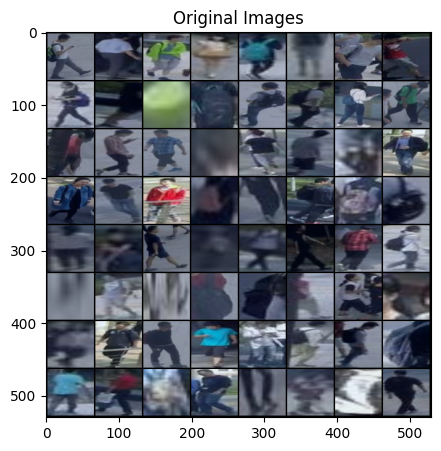

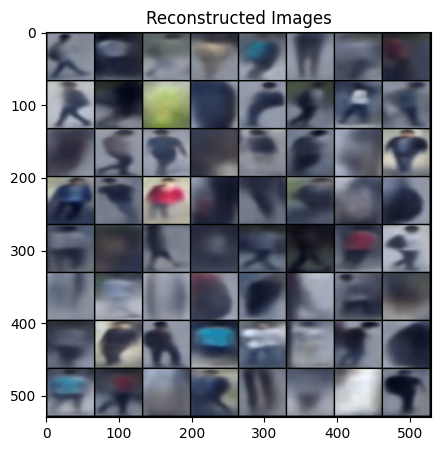

In [12]:
# Get a batch of images from your dataloader
dataiter = iter(train_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images)[-1]  # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

### Loss on Train Set

In [13]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in train_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # Forward pass through the encoder and then the decoder
            latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            reconstructed_imgs = decoder(latent_representation)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the train set: {average_loss}')


Average reconstruction loss on the train set: 0.26163185493399155


### Save Model Dict

In [14]:
# Save the decoder state dictionary
torch.save(decoder.state_dict(), 'decoder_t8_preds_detr101dc5_adamw_numblocks_1_ffdim_4096_heads_16_v2.pth')

### TODO: Declare Test Dataloader

In [ ]:
test_dataset = datasets.ImageFolder(root='./datasets/Avenue Dataset/objects/test/', transform=transform)

# Create the DataLoader to load the dataset.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

print(test_dataset)

### Visualize Reconstruction Loss on Test Batch

In [ ]:
# Get a batch of images from your dataloader
dataiter = iter(test_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images)[-1]  # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

### Loss on Test Set

In [ ]:
total_loss = 0.0
total_batches = 0

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for images, _ in test_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        images = images.to(device)

        with torch.no_grad():
            # Forward pass through the encoder and then the decoder
            latent_representation = encoder(images)[-1]  # Assuming the last output is the latent representation
            reconstructed_imgs = decoder(latent_representation)

        # Compute the reconstruction loss
        loss = F.mse_loss(reconstructed_imgs, images)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1

# Calculate the average loss over all batches
average_loss = total_loss / total_batches
print(f'Average reconstruction loss on the test set: {average_loss}')

## UBNormal